# Examples using ``RBM.py`` and ``Autoencoder.py``

This notebook demonstrates use cases for the two classes defined in this repository. There are also brief discussions of restricted Boltzmann machines in Section 1 and pretraining deep autoencoders in Section 2.A.

1. Restricted Boltzmann machines with ``RBM.py``
2. Using ``Autoencoder.py`` to pretrain a deep autoencoder.
  1. A word about deep autoencoders
  2. Pretraining with ``Autoencoder.py``
3. Applications of deep autoencoders:
  1. Classification
  2. Cluster analysis
  3. Generation
  4. 2D Visualization

# 1. Restricted Boltzmann machines with ``RBM.py``

Restricted Boltzmann machines are the building block for pretraining our deep autoencoder. In this section, we demonstrate how ``RBM.py`` can be used on it's own.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from RBM import *

We will train our RBM's on the MNIST data set for a demonstration. Since Boltzmann machines model binary data, we first convert our greyscale images to black and white by choosing a threshold greyscale value.

### Loading the data

In [222]:
# helper fcn
import struct
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape) 

In [223]:
# get the files yourself from http://yann.lecun.com/exdb/mnist/
# load training data

x    = read_idx("train-images-idx3-ubyte").reshape((60000,784)).T/255.
x_bw = (x > 0.705).astype(int)  

y = np_utils.to_categorical(read_idx("train-labels-idx1-ubyte"))

# load test data

test_images    = read_idx("t10k-images-idx3-ubyte").reshape((10000,784)).T/255.
test_images_bw = (test_images > 0.705).astype(int)
test_labels    = np_utils.to_categorical(read_idx("t10k-labels-idx1-ubyte"))

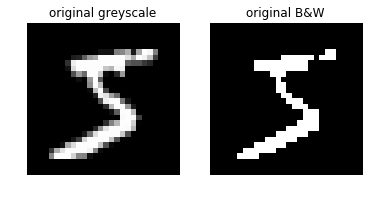

In [224]:
# here is an example of an image from MNIST, converted to B&W
f, ax = plt.subplots(1,2, sharex=True)
ax[0].imshow(x[:,0].reshape((28,28)),cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title("original greyscale")
ax[1].imshow(x_bw[:,0].reshape((28,28)),cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title("original B&W")

plt.show()

### Loading a trained RBM

A RBM model can be trained on this data set by first initializing an RBM object, and then running the training algorithm, which performs the contrastive divergence algorithm of Hinton. 

    rbm = RBM(v_dim = 784, h_dim = 1000)
    rbm.train(x, epochs = 20, batch_size = 20, learning_rate = .1, plot=False)
    
When initializing a RBM object from scratch, ``v_dim`` is the number of visible units and ``h_dim`` is the number of hidden units.  There is also the option to initialize a new RBM object from pretrained weights or from a file (demonstrated below).

The training algorithm uses minibatches, and has the option (``plot=True``) of plotting weight histograms to help with debugging.  Once a RBM has been trained, the weights can be saved to a file by calling ``rbm.save(filename)``.

By default, the training algorithm initializes weights when it is run. If you want to continue training from previous weights, include the optional argument ``initialize_weights = True``.

Since training a RBM can take some time, we will load a pretrained model (that was trained on MNIST using the lines of code above).

In [225]:
# load pre-trained RBM
rbm = RBM.from_File("./trained_weights/rbm/20_epochs")

### Data reconstruction

The first goal in training a RBM is to be able to reconstruct examples well. Let's try this first on examples from the training set.

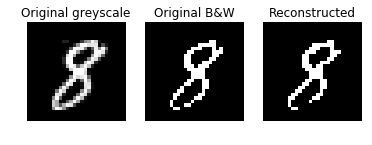

In [198]:
image_no = 20 # change this number to compare other reconstructed digits

v,_ = rbm.gibbs_sampling(1,1,x_bw[:,image_no].reshape((784,1)))

# plot
f, ax = plt.subplots(1,3, sharex=True)
ax[0].imshow(x[:,image_no].reshape((28,28)),cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title("Original greyscale")
ax[1].imshow(x_bw[:,image_no].reshape((28,28)),cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title("Original B&W")
ax[2].imshow(v.reshape((28,28)),cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title("Reconstructed")
plt.show()

Next, let's see how the RBM reconstructs images from the yet-unseen test set.

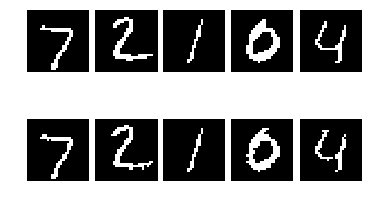

In [227]:
f, ax = plt.subplots(2,5,sharex=True)

for i in range(5):
    ax[0,i].imshow(test_images_bw[:,i].reshape((28,28)),cmap=plt.cm.gray)
    ax[0,i].axis('off')
    
    v,_ = rbm.gibbs_sampling(1,1,test_images_bw[:,i].reshape((784,1)))
    ax[1,i].imshow(v.reshape((28,28)),cmap=plt.cm.gray)
    ax[1,i].axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=.0)
plt.show()

### Data generation

Finally, let's see how well the RBM generates images from random noise.

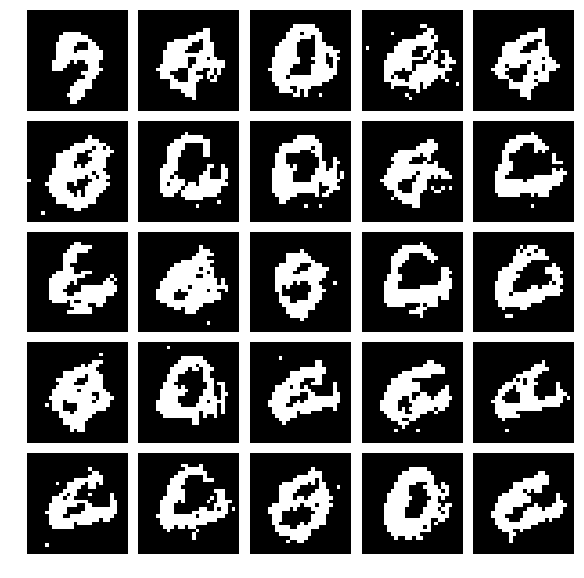

In [244]:
# randomly generate an image (would benefit from more epochs of training)

v,_ = rbm.gibbs_sampling(100,25) # if no data is passed to the sampling fcn, it starts with random noise

f, ax = plt.subplots(5,5, figsize=(10,10),sharex=True)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(v[:,5*i+j].reshape((28,28)),cmap=plt.cm.gray)
        ax[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=.1)
plt.show()

# 2. Using ``Autoencoder.py`` to pretrain a deep autoencoder.

## A. A word about deep autoencoders

Theoretically, deep autoencoders are ideal models to have when you want to deal with high-dimensional data. They provide a compressed representation that retains information and can be used for many purposes. If the compressed representation an autoencoder learns is "good" then it can be used for classification and data generation tasks, as well as more exploratory tasks like cluster analysis and visualization.  Although there are many other dimensionality reduction algorithms like PCA, autoencoders generally perform much better than alternatives if the dimension is sufficiently large (cf. Hinton-Salakhutdinov, 2006). 

The difficulty with deep autoencoders is that the loss function is highly non-convex and learning with gradient-descent using random weight initializations can result in learning "bad" representations that lose vital information. 

One solution to this problem (among many others, such as sparse and variational autoencoders) is to first perform greedy layer-wise pretraining of the weights with restricted Boltzmann machines. This seems to resolve the problem of bad initializations (cf. Erhan et al., 2010). 

[1] Hinton and Salakhutdinov, 2006. "Reducing the Dimensionality of Data with Neural Networks." Science.

[2] Erhan et al., 2010. "Why Does Unsupervised Pre-training Help Deep Learning?" J. Mach. Learn. Res.

## B. Pretraining with ``Autoencoder.py``

The class ``Autoencoder`` performs layerwise pretraining with RBMs, then unrolls the layers into a deep autoencoder model. The pretrained deep autoencoder is returned as a Keras model, which the user can then take and fine-tune with gradient descent.

Here is a brief example of how it might work in practice. In the next section we will load weights from a model that has been trained much longer (and has a better achitecture, in terms of layer dimensions).

In [6]:
from keras.models import Model
from Autoencoder import *

example_autoencoder = Autoencoder(layer_dims = [784,200,30])

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Layer dimensions:
Layer 0: 784
Layer 1: 200
Layer 2: 30


In [8]:
example_autoencoder.pretrain(x,epochs = 1,num_samples = 1000)
example_model = example_autoencoder.unroll()

Training RBM layer 1
Epoch 1
Training RBM layer 2
Epoch 1


In [9]:
example_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               6200      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               157584    
Total params: 326,814
Trainable params: 326,814
Non-trainable params: 0
_________________________________________________________________


# 3. Applications of autoencoders

In this section, we demonstrate various use cases for a trained autoencoder. Since training a deep autoencoder can take some time, we load a model that we have already trained.

This model was trained as follows:
1. First the model was pretrained using ``Autoencoder.py`` for 10 epochs on each layer (generating 50000 samples each time for the training of the next layer).
2. Second, the model was fine-tuned in Keras for 4 epochs, using mostly default parameters (rmsprop, mse, batch size = 20).

In [245]:
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense

In [246]:
# load the model, which we have pretrained and then fine-tuned 
model = load_model("trained_weights/fine-tuned/keras_model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                7530      
_________________________________________________________________
dense_5 (Dense)              (None, 250)               7750      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               125500    
__________

## A. Classification

If the encoder portion of an autoencoder has learned a "good" compression/coding of the data, then the outputs of the encoder (the codes) should retain enough information to make classification possible. On the other hand, if the autoencoder learned a bad coding, using codes for classification should be impossible.

A classifier is created by composing the encoder portion of the network with a shallow neural network for classification (in this case, 2 layers with a softmax output and L2 regularization). Since the codes should retain useful information for classification, the weights of the encoder network are left frozen while training.

In [151]:
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import regularizers
from livelossplot import PlotLossesKeras

In [152]:
# build the classifier model

inputs = Input(shape=(784,))

# the encoder layers of the autoencoder model
# these layers are frozen

layer1 = model.get_layer("dense_1")
X = layer1(inputs)
layer1.trainable = False

layer2 = model.get_layer("dense_2")
X = layer2(X)
layer2.trainable = False

layer3 = model.get_layer("dense_3")
X = layer3(X)
layer3.trainable = False

layer4 = model.get_layer("dense_4")
X = layer4(X)
layer4.trainable = False

# we add a 2-layer neural network for classification. This part has trainable weights
X = Dense(20,kernel_regularizer=regularizers.l2(0.005))(X)
Y = Dense(10, activation='softmax')(X)
            
classifier = Model(inputs,Y)

classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                7530      
_________________________________________________________________
dense_17 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                210       
Total para

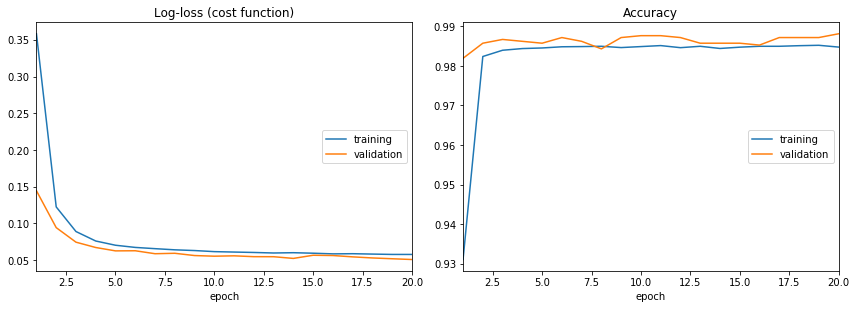

In [153]:
classifier.fit(x.T,y,epochs=20,validation_split=.05,callbacks=[PlotLossesKeras()])

In [247]:
score = classifier.evaluate(test_images.T,test_labels)

print("Classifier accuracy on test set = %.2f%%"%(score[1]*100))


10000/10000 [==============================] - 2s 167us/step
Classifier accuracy on test set = 98.05%


While certainly not state-of-the-art, this is decent accuracy. Our autoencoder has leared a 30 dimensional representation of the data that doesn't lose a significant amount of information about classification.

## B. Using encoded data for cluster analysis

If the autoencoder has learned a good compression of the data, then the 30 dimensional codes should be suitable for cluster analysis.



In [250]:
# build the encoder model

inputs = Input(shape=(784,))

# the encoder layers of the autoencoder model
# these layers are frozen

layer1 = model.get_layer("dense_1")
X = layer1(inputs)
layer1.trainable = False

layer2 = model.get_layer("dense_2")
X = layer2(X)
layer2.trainable = False

layer3 = model.get_layer("dense_3")
X = layer3(X)
layer3.trainable = False

layer4 = model.get_layer("dense_4")
Y = layer4(X)
layer4.trainable = False
            
encoder = Model(inputs,Y)

encoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                7530      
Total params: 1,418,280
Trainable params: 0
Non-trainable params: 1,418,280
_________________________________________________________________


We use ``encoder`` to compress the training data to 30 dimensional vectors.

In [252]:
codes = encoder.predict(x.T)

In [270]:
codes[0]

array([-2.2913525 ,  3.3301835 ,  7.0630836 , -2.246519  ,  2.201845  ,
       -2.5212908 ,  0.35492405, 10.238344  ,  3.7134655 , -1.5280493 ,
       -5.23599   , -6.45432   ,  5.9130554 , -1.2898684 ,  4.1333323 ,
       -1.8035772 , -1.2061745 ,  1.0972081 , -9.438332  ,  0.2425302 ,
       -2.1914582 ,  0.15309489, -4.6018476 , -5.250745  , -0.60072404,
       -2.412487  , -7.169611  , -4.7054787 ,  4.960115  ,  4.8273478 ],
      dtype=float32)

### Code distribution

In order to gain insight into the codes created by the encoder, let's plot some basic information about them.

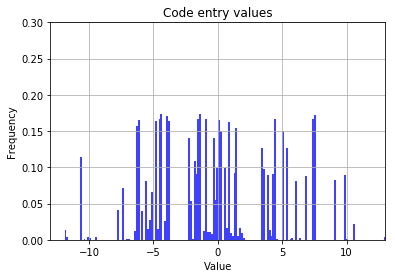

In [269]:
n, bins, patches = plt.hist(codes, 5,density=True, facecolor='b', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Code entry values')
plt.axis([-13, 13, 0, .3])
plt.grid(True)
plt.show()

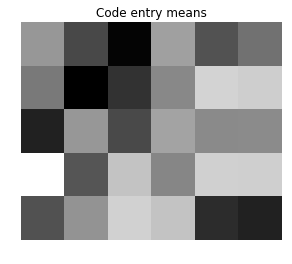

[[-1.8361785   3.3848429   7.86609    -2.4334025   2.617788    0.56163514]
 [ 0.1497685   8.141076    4.765127   -0.8515972  -5.896228   -5.5220375 ]
 [ 5.894301   -1.8572944   3.2929423  -2.6655407  -0.97429115 -1.0957441 ]
 [-8.766015    2.4738386  -4.856585   -0.7365177  -5.625187   -5.546479  ]
 [ 2.7168913  -1.6339879  -5.6840205  -4.840582    5.2115965   5.8746786 ]]


In [285]:
mean = np.mean(codes,axis=0).reshape((5,6))

plt.imshow(mean, cmap='binary', interpolation='nearest')
plt.title("Code entry means")
plt.axis('off')
plt.show()

print(mean)

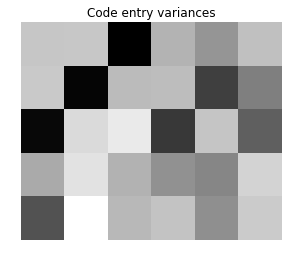

[[1.9013717 1.896165  3.8908253 2.0841541 2.395903  1.9623002]
 [1.8757001 3.832846  2.0097847 1.9990046 3.255557  2.6128914]
 [3.7960765 1.7024859 1.544936  3.319357  1.9188695 2.9331574]
 [2.188781  1.6210797 2.1013472 2.4315732 2.544603  1.7730525]
 [3.0568364 1.3284072 2.0428433 1.9257643 2.4498227 1.8579967]]


In [286]:
var = np.var(codes,axis=0).reshape((5,6))

plt.imshow(var, cmap='binary', interpolation='nearest')
plt.title("Code entry variances")
plt.axis('off')
plt.show()

print(var)

## C. Generation

In order to perform generation, we should use a sigmoid activation for all layers.

In [248]:
# build the generator/decoder model

noise = Input(shape=(30,))
X = model.get_layer("dense_5")(noise)
X = model.get_layer("dense_6")(X)
X = model.get_layer("dense_7")(X)
Y = model.get_layer("dense_8")(X)
            
decoder = Model(noise,Y)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               7750      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               784784    
Total params: 1,419,034
Trainable params: 1,419,034
Non-trainable params: 0
_________________________________________________________________


[ 2.52402614 -1.44022483 -3.33258078 -7.16677628  6.78243566  3.279462
  9.76128883 -8.09606264 -2.05432973 -4.59238853  8.15735814 -4.18807631
  6.29590593 -1.61145364  0.2642908  -1.00609818 -5.73843329  4.97587672
 -9.54302543 -5.27845543 -3.08638842  8.40087959 -2.0164632  -4.80795994
 -0.52806809 -2.14771821 -4.16599102  1.16973731 -9.33589312  6.6886695 ]


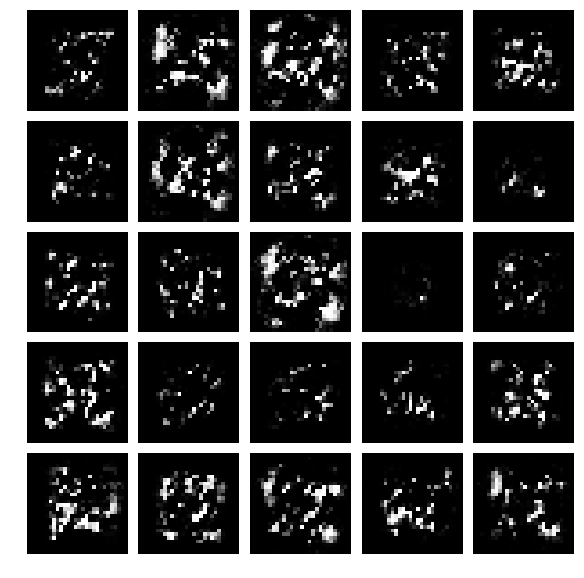

In [287]:
noise = 20*np.random.random((25,30))-10
print(noise[0])
image = 255.*decoder.predict(noise)

f, ax = plt.subplots(5,5, figsize=(10,10),sharex=True)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(image[5*i+j].reshape((28,28)),cmap=plt.cm.gray)
        ax[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=.1)
plt.show()

## D. Visualization

To get a 2D visualization, train an autoencoder whose code layer has dimension 2.

We've already pretrained several layers of our autoencoder for clustering and classification, so we just need to pretrain one final layer. Let's be lazy and use the first 4 layers of our fine-tuned model to generate the training data for the final RBM layer.

In [178]:
data = df.values[:,1:]/255

# in case you haven't run the cells in the previous section, load the trained autoencoder from file
model = load_model("trained_weights/keras_model.h5")

inputs = Input(shape=(784,))

layer1 = model.get_layer("dense_1")
X = layer1(inputs)

layer2 = model.get_layer("dense_2")
X = layer2(X)

layer3 = model.get_layer("dense_3")
Y = layer3(X)
            
model_first_three_layers = Model(inputs,Y)
model_first_three_layers.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

training_data = model_first_three_layers.predict(data)
training_data = (training_data>.5)

In [182]:
training_data.shape

(42000, 250)

In [183]:
# train a final RBM layer
from RBM_with_linear_hidden_units import *

final_layer = RBM_with_linear_hidden_units(v_dim = 250, h_dim = 2)
final_layer.train(training_data.T,
                  epochs = 10, 
                  batch_size = 20, 
                  learning_rate = .1, 
                  plot=True)

Epoch 1


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


AssertionError: 